In [2]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model

import os
import cv2
from tqdm import tqdm
import random
from random import shuffle
import numpy as np         # dealing with arrays
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from os import makedirs
from os import listdir
from imutils import paths
from random import seed
from random import random
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from random import random, shuffle
import pathlib

Using TensorFlow backend.
c:\users\61423\anaconda3\envs\ml3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\61423\anaconda3\envs\ml3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\61423\anaconda3\envs\ml3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\61423\anaconda3\envs\ml3.7\lib\site-pa

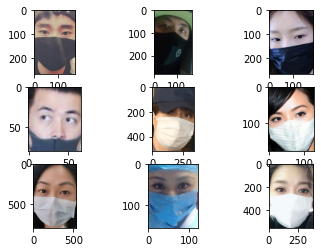

In [39]:
# define location of dataset
with_folder = 'data/with_mask/'
without_folder = 'data/without_mask/'
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = with_folder + 'with (' + str(i + 1) + ').jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

In [40]:
#Creating training and testing directories

dataset_home = 'with_vs_without/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['with/', 'without/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

In [6]:
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.20
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(with_folder):
    if file.endswith('jpg'):
        src = with_folder  + file
        dst_dir = 'with_vs_without/train/with/'
        if random() < val_ratio:
            dst_dir = 'with_vs_without/test/with/'
        photo = load_img(src, target_size=(200, 200))
        photo.save(dst_dir+file)
        
for file in listdir(without_folder):
    if file.endswith('jpg'):
        src = without_folder  + file
        dst_dir = 'with_vs_without/train/without/'
        if random() < val_ratio:
            dst_dir = 'with_vs_without/test/without/'
        photo = load_img(src, target_size=(200, 200))
        photo.save(dst_dir+file)
    

In [41]:
IMG_SIZE=64
ROWS = 128
COLS = 128
CHANNELS = 3

In [42]:
TRAIN_DIR='with_vs_without/train/'
TEST_DIR='with_vs_without/test/'

train_images = list(paths.list_images(TRAIN_DIR))
test_images =  list(paths.list_images(TEST_DIR))

train_images_with = list(paths.list_images(TRAIN_DIR+'/with'))
train_images_without = list(paths.list_images(TRAIN_DIR+'/without'))


In [43]:
#function for preprocess the data
def create_train_data(images):

    count = len(images)
    training_data = np.ndarray((count,  ROWS, COLS,CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        img = cv2.imread((image_file), cv2.IMREAD_COLOR)
        b, g, r = cv2.split(img)
        img2 = cv2.merge([r, g, b])
        img2 = cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
        training_data[i] = img2
        if i % 1000 == 0: print('Processed {} of {}'.format(i, count))
    return training_data

In [44]:
train_images = train_images_with[:2000] + train_images_without[:2000]

In [45]:
#images for validation
val_images = train_images_with[0:100] + train_images_without[0:100]
shuffle(val_images)

shuffle(train_images)  #shuffle trainig samples
shuffle(test_images)
test_images =  test_images[:100]

In [46]:
train_data = create_train_data(train_images)
np.save('train_data.npy', train_data)

Processed 0 of 2960
Processed 1000 of 2960
Processed 2000 of 2960


In [48]:
val_data = create_train_data(val_images)

test_data = create_train_data(test_images)

print("Train shape: {}".format(train_data.shape))
print("val shape: {}".format(val_data.shape))
print("Test shape: {}".format(test_data.shape))

Processed 0 of 200
Processed 0 of 100
Train shape: (2960, 128, 128, 3)
val shape: (200, 128, 128, 3)
Test shape: (100, 128, 128, 3)


In [49]:
labels = []
for (i, imagePath) in enumerate(train_images):
    path1 = pathlib.PurePath(imagePath)
    label = path1.parent.name
   
    if 'without' in label:
        labels.append(1)
    else:
        labels.append(0)

c:\users\61423\anaconda3\envs\ml3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

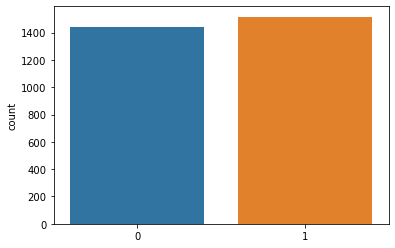

In [50]:
# Graphical display of num of images in training set
sns.countplot(labels)

In [51]:
val_labels = []
for (i, imagePath) in enumerate(val_images):
    
    path1 = pathlib.PurePath(imagePath)
    label = path1.parent.name
    
    if 'without' in label:
        val_labels.append(1)
    else:
        val_labels.append(0)

c:\users\61423\anaconda3\envs\ml3.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

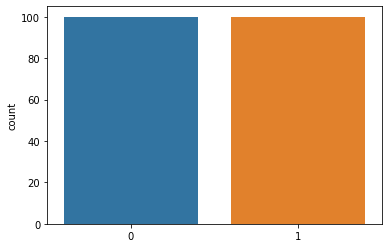

In [52]:
sns.countplot(val_labels)
#just displaying ratio in validation set

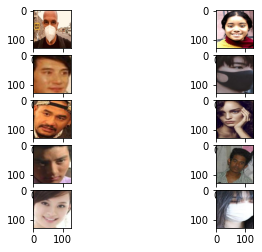

In [53]:
fig=plt.figure()


plt.ion()

def show_with_and_without(idx):
    img = ((train_data[idx]))
    img = img

    fig.add_subplot(5,2,( idx+1))
    plt.imshow((img))
    
for idx in range(0, 10):
    show_with_and_without(idx)


plt.show()

In [54]:
batch_size = 16
num_classes = 2
epochs = 50 #50 #100
data_augmentation = True

In [55]:
optimizer = keras.optimizers.rmsprop(lr=1e-4)   # options for other optimizer https://keras.io/optimizers/
objective = 'binary_crossentropy'

## CNN

In [56]:
def withwithout():
    model = Sequential()
    print("First layer...")
    model.add(Conv2D(32, 3, padding='same', input_shape=train_data.shape[1:], activation='relu')) #adding layer
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    print("Second layer...")
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    #print("Third layer...")
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(Conv2D(128, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    #print("Fourth layer...")
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


    print("Flattening, etc...")
    model.add(Flatten())                   # fully connected layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

In [57]:
### Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

In [58]:
print("Creating model:")
model = withwithout()

Creating model:
First layer...
Second layer...
Flattening, etc...
Compiling model...


In [59]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
history = LossHistory()  

In [60]:
if not data_augmentation:
    print('Not using data augmentation.')

    model.fit(train_data, labels,
              batch_size=batch_size,
              epochs=epochs,
              #validation_split=0.25,
              validation_data=(val_data, val_labels),
               verbose=2,
              shuffle=True,callbacks=[history, early_stopping])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
        
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_data)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_data, labels,  batch_size=batch_size),
                        epochs=epochs,
                        #validation_split=0.25,
                        validation_data=(val_data, val_labels),
                        callbacks=[history, early_stopping],
                        workers=4)

Using real-time data augmentation.
Epoch 1/50
185/185 [==============================] - 537s 3s/step - loss: 0.5289 - acc: 0.7750 - val_loss: 0.1402 - val_acc: 0.9400
Epoch 2/50
185/185 [==============================] - 485s 3s/step - loss: 0.2905 - acc: 0.9044 - val_loss: 0.1423 - val_acc: 0.9450
Epoch 3/50
185/185 [==============================] - 483s 3s/step - loss: 0.2552 - acc: 0.9176 - val_loss: 0.0939 - val_acc: 0.9700
Epoch 4/50
185/185 [==============================] - 432s 2s/step - loss: 0.2246 - acc: 0.9257 - val_loss: 0.0729 - val_acc: 0.9600
Epoch 5/50
185/185 [==============================] - 458s 2s/step - loss: 0.2187 - acc: 0.9304 - val_loss: 0.0802 - val_acc: 0.9600
Epoch 6/50
185/185 [==============================] - 450s 2s/step - loss: 0.2412 - acc: 0.9324 - val_loss: 0.1786 - val_acc: 0.9350
Epoch 7/50
185/185 [==============================] - 439s 2s/step - loss: 0.2260 - acc: 0.9324 - val_loss: 0.1280 - val_acc: 0.9550
Epoch 8/50
185/185 [==============

In [62]:
model.save('mask_detection_model_v8final.h5')

In [63]:
loss = history.losses
val_loss = history.val_losses
print('val_loss')
print(val_loss)
print('loss')
print(loss)

val_loss
[0.14016011640429496, 0.1423208599258214, 0.09393519520759583, 0.07293433599174022, 0.08019113916438073, 0.17855982661247252, 0.12803664416074753, 0.11931414894759655, 0.08725235065445304, 0.043451723997714, 0.10455748185515404, 0.04921257670968771, 0.09100701615214347, 0.042956748470314776, 0.07723038325319066, 0.08174031091621145, 0.14796116930927383, 0.11086102481931448, 0.16843992602270247, 0.03165460663089106, 0.06641960278153419, 0.03245672624441795, 0.0390672242749406, 0.0481971682747826, 0.07817128291293102, 0.16877008456791315, 0.07829827905696675]
loss
[0.5288801988637125, 0.2905115142187758, 0.25523215955425355, 0.22460389087681432, 0.21873868223581766, 0.24121862313225614, 0.22602930462366497, 0.19720910102820396, 0.23128089104917504, 0.2121903471123251, 0.20115212002800378, 0.18352095057495005, 0.18288215758948845, 0.1797013990758301, 0.19455408358433585, 0.19908752090510903, 0.29770685199006053, 0.16945916909261713, 0.20852260160154124, 0.1965709263934416, 0.2519

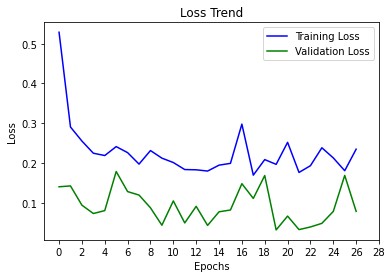

In [64]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,30)[0::2])
plt.legend()
plt.show()

val_acc
[0.94, 0.945, 0.97, 0.96, 0.96, 0.935, 0.955, 0.975, 0.975, 0.975, 0.97, 0.975, 0.97, 0.975, 0.97, 0.965, 0.97, 0.95, 0.98, 0.975, 0.98, 0.985, 0.985, 0.98, 0.97, 0.98, 0.985]
acc
[0.775, 0.9043918918918918, 0.9175675675675675, 0.9256756756756757, 0.9304054054054054, 0.9324324324324325, 0.9324324324324325, 0.9364864864864865, 0.9354729729729729, 0.9371621621621622, 0.9472972972972973, 0.9462837837837837, 0.9476351351351351, 0.9489864864864865, 0.9523648648648648, 0.9523648648648648, 0.9452702702702702, 0.9557432432432432, 0.95, 0.9611486486486487, 0.9486486486486486, 0.956081081081081, 0.9567567567567568, 0.9493243243243243, 0.9621621621621622, 0.956081081081081, 0.9550675675675676]


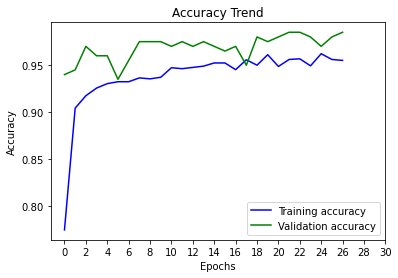

In [65]:
val_acc = history.val_acc
acc = history.acc
print('val_acc')
print(val_acc)
print('acc')
print(acc)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trend')
plt.plot(acc, 'blue', label='Training accuracy')
plt.plot(val_acc, 'green', label='Validation accuracy')
plt.xticks(range(0,32)[0::2])
plt.legend()
plt.show()

In [66]:
scores = model.evaluate(val_data, val_labels, verbose=1)

200/200 [==============================] - 7s 35ms/step


In [67]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.07829826801840682
Test accuracy: 0.985


In [68]:
model_layers = [ layer.name for layer in model.layers]  #laeyrs
print(model_layers)

['conv2d_10', 'conv2d_11', 'max_pooling2d_5', 'conv2d_12', 'conv2d_13', 'max_pooling2d_6', 'conv2d_14', 'conv2d_15', 'max_pooling2d_7', 'conv2d_16', 'conv2d_17', 'conv2d_18', 'max_pooling2d_8', 'flatten_2', 'dense_4', 'dropout_3', 'dense_5', 'dropout_4', 'dense_6', 'activation_2']


In [1]:
predictions = model.predict(test_data, verbose=0)

NameError: name 'model' is not defined

In [70]:
test_data.shape

(100, 128, 128, 3)

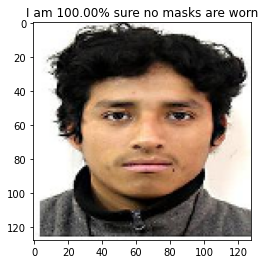

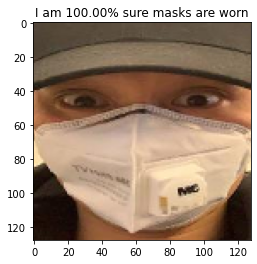

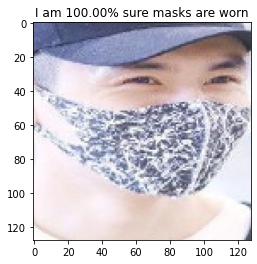

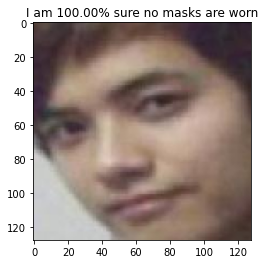

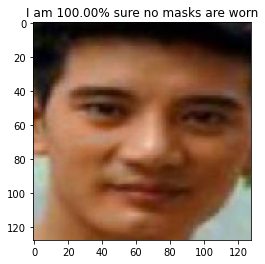

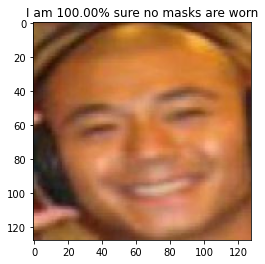

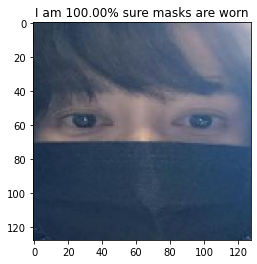

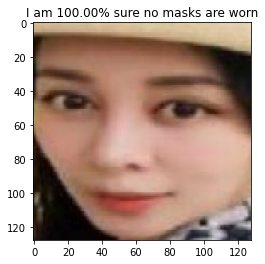

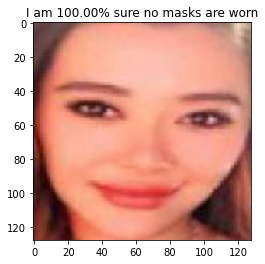

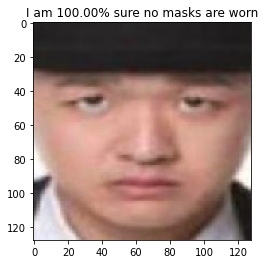

In [71]:
for i in range(0, 10): 
    tmp = test_data[i]
    plt.imshow(tmp)
    if predictions[i, 0] >= 0.5:
        plt.title('I am {:.2%} sure no masks are worn'.format(predictions[i][0],4))
    else:
        plt.title('I am {:.2%} sure masks are worn'.format(1 - predictions[i][0],4))


    #plt.title('feature map {}'.format(i + 1))
    plt.show()

# Live Classifier

In [32]:
#Test Input
face_img=imread('faces_detected.jpg')
resized=cv2.resize(face_img,(128,128))
normalized=resized
reshaped=np.reshape(normalized,(1,128,128,3))
reshaped = np.vstack([reshaped])
result=model.predict(reshaped)
print(result[0][0])

if result[0][0] > 0.6:
    label = 1
else:
    label = 0
print(label)

1.0
0
1


In [3]:
#FINAL CLASSIFIER
import cv2;
model = load_model('mask_detection_model_final.h5')
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml');
video = cv2.VideoCapture(0);

while True:
    check, frame = video.read();
    faces = face_cascade.detectMultiScale(frame, minNeighbors=3, minSize=(100,100));
    
    for x,y,w,h in faces:
        face = frame[y:y + h , x:x + w] 
        cv2.imwrite('faces_detected.jpg', face)
        face_img=imread('faces_detected.jpg')
        resized=cv2.resize(face_img,(128,128))
        normalized=resized
        reshaped=np.reshape(normalized,(1,128,128,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        print(result[0][0])

        if result[0][0] > 0.5:
            label = 1
            frame = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 2);
            cv2.putText(frame, "No Mask", (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        else:
            label = 0
            frame = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0), 2);
            cv2.putText(frame, "Mask on", (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        print(label)

    cv2.imshow('Face Detector', frame);

    key = cv2.waitKey(1);

    if key == ord('q'):
        break;

video.release();
cv2.destroyAllWindows();

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.9980719
1
0.9984464
1
0.99938893
1
0.99938905
1


KeyboardInterrupt: 

In [1]:
model6 = load_model('mask_detection_model_final.h5')
model6.summary()

NameError: name 'load_model' is not defined